# Overall Goals

I will use the subset of available data in this workspace to begin analyzing churn in the "Sparkify" 128 MB example data set using a Spark framework. It will be possible to scale the work here to the larger 12 GB full data set because it is programmed using Spark.

The project will involve several steps:
1. Loading and Cleaning Data
2. Exploratory Data Analysis
3. Feature Engineering
4. Classification Modeling

First, I import a variety of pyspark libraries and begin the spark session

In [2]:
# Import libraries that we will use in the rest of the project
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql import Window
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, sum, max
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Project") \
    .getOrCreate()

# Load and Preprocess the Data

Load the data set using the path for the project workspace

In [4]:
# Set path and load dataset
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [5]:
# Check first few entries to get an idea of the data
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

Session ID and User ID fields have NaN values in some places.  There are not many, so we can drop the relevant rows which we cannot easily connect to a given user/session.  We can also remove rows with no User ID at all.

In [6]:
# Drop entries missing values for userID or sessionId
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")


I want to find the total number of log entries in the data set to get a sense of scale

In [7]:
# Find the total number of log entries
user_log_valid.count()

278154

Print the overall schema for the data to see what options we have for feature extraction.  Also, examine the possible page options as those could be useful for creating features.

In [7]:
# What are the existing data fields
# Check Schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Show all possible results for page and check for blanks
user_log_valid.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



# Exploratory Data Analysis

Take a first look at the data by examing several entries and seeing what the page time series looks like for a single user

In [9]:
#First look at what data looks like
# Check first few entries
user_log_valid.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [12]:
# Look at example series of entries for one user
user_log_valid.select("ts","page").where(user_log_valid.userId == 30).show(10)

+-------------+---------------+
|           ts|           page|
+-------------+---------------+
|1538352117000|       NextSong|
|1538352394000|       NextSong|
|1538352676000|       NextSong|
|1538352899000|       NextSong|
|1538352905000|Add to Playlist|
|1538353084000|       NextSong|
|1538353218000|       NextSong|
|1538353441000|       NextSong|
|1538353687000|       NextSong|
|1538353909000|       NextSong|
+-------------+---------------+
only showing top 10 rows



### Define Churn

Define a new column for churn called "downgraded" by flagging events where users either submitted downgrades or canceled subscriptions overall

In [14]:
# Make function for flagging downgrade/delete account events
flag_downgrade_event = udf(lambda x: 1 if (x == "Submit Downgrade" or x == "Cancel") else 0, IntegerType())

In [15]:
# Add downgrade feature to user log
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

Parititioning the data set by user gives us a time series of user activity.  If a series ends with a churn event, we can classify them differently than users who didn't churn.

In [16]:
# Partition the data set by user
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# Add Phase feature to user log
user_log_valid = user_log_valid.withColumn("phase", sum("downgraded").over(windowval))


### Explore Data
Explore the data by examining parameters which might be useful for modelling later.

Examine the possible values for the gender and level parameters, two things which might effect churn and are easy to turn into features

In [17]:
# Show details of level field
user_log_valid.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [18]:
# Show details of gender field
user_log_valid.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



Visualize an example time series of how a user transitions between phases - a paid and free subscription level in this case.

In [19]:
# Example Results of windowing
user_log_valid.select(["userId", "sessionId", "page", "level", "phase", "downgraded"]).where(user_log.userId == "30").sort("sessionId").collect()

[Row(userId='30', sessionId=29, page='Add to Playlist', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='Roll Advert', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, page='NextSong', level='paid', phase=1, downgraded=0),
 Row(userId='30', sessionId=29, p

Perform a few more searches to estimate how many positive and negative results we will have in our data set when trying to model churn.

In [20]:
# Find how many accounts were downgraded in the data set
user_log_valid.select("downgraded").where(user_log_valid.downgraded==1).count()

115

In [21]:
# Find total number of user/phase combinations
user_log_valid.select("userId","phase").dropDuplicates().count()

339

Ultimately, the number of useres will reflect the user-phase combinations, as if a user downgrades their account and then later deletes it, we want to consider both events as examples of churn.

In [22]:
# Find total number of sessions
user_log_valid.select("sessionId").dropDuplicates().count()

2312

# Feature Engineering


We need to create features from our data set to allow for modelling later.  various transoformations are used to create features that might be useful for churn prediction.

First, create features for gender and subscription level by flagging the appropriate values and adding new columns.

In [23]:
# Add feature for Gender
# Function to flag gender
flag_male = udf(lambda x: 1 if x == "M" else 0, IntegerType())
flag_female = udf(lambda x: 1 if x == "F" else 0, IntegerType())

# Add Gender feature to user log
user_log_valid = user_log_valid.withColumn("Male", flag_male("gender"))
user_log_valid = user_log_valid.withColumn("Female", flag_female("gender"))

In [24]:
# Add feature for subscription level
# Function to free or paid levels
flag_paid = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
flag_free = udf(lambda x: 1 if x == "free" else 0, IntegerType())

# Add Gender feature to user log
user_log_valid = user_log_valid.withColumn("Paid", flag_paid("level"))
user_log_valid = user_log_valid.withColumn("Free", flag_free("level"))

Next, I want to look at the frequency of different page events as those might be useful.  If a user spend a lot of time on certain pages, that might suggest they are having a good or bad time using the service.

Start by flagging key page actions and adding relevant columns.

In [26]:
# Make functions for flagging key page actions
flag_thumbsdown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
flag_thumbsup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
flag_rolladvert_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
flag_settings_event = udf(lambda x: 1 if x == "Settings" else 0, IntegerType())
flag_addtoplaylist_event = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
flag_addfriend_event = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
flag_help_event = udf(lambda x: 1 if x == "Help" else 0, IntegerType())
flag_error_event = udf(lambda x: 1 if x == "Error" else 0, IntegerType())
flag_song_event = udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())

In [27]:
# Add page event flags to the user log
user_log_valid = user_log_valid.withColumn("thumbsdown", flag_thumbsdown_event("page"))
user_log_valid = user_log_valid.withColumn("thumbsup", flag_thumbsup_event("page"))
user_log_valid = user_log_valid.withColumn("advert", flag_rolladvert_event("page"))
user_log_valid = user_log_valid.withColumn("settings", flag_settings_event("page"))
user_log_valid = user_log_valid.withColumn("addtoplaylist", flag_addtoplaylist_event("page"))
user_log_valid = user_log_valid.withColumn("friend", flag_addfriend_event("page"))
user_log_valid = user_log_valid.withColumn("help", flag_help_event("page"))
user_log_valid = user_log_valid.withColumn("error", flag_error_event("page"))
user_log_valid = user_log_valid.withColumn("song", flag_error_event("page"))

Next, sum the number of visits to given pages over session ID to find how often different events happen for a user for a given session.

In [28]:
# First aggregation to find numbers of key page events using flags for each session
agg1 = user_log_valid.groupBy('userId','sessionId').agg({'thumbsdown':'sum', 'thumbsup':'sum', 'advert':'sum', 
                                                     'settings':'sum', 'addtoplaylist':'sum', 'friend':'sum',
                                                     'help':'sum', 'error':'sum', 'downgraded':'max', 'song':'sum',
                                                     'Male':'max','Female':'max','Paid':'max','Free':'max',
                                                     'phase':'max'})

Then, we aggregate again over user and phase to determine the average amount of times an event happens in a session for a given churn/non-churn data point to see what typical behavior looks like.

In [29]:
agg2 = agg1.groupBy('userId','max(phase)').agg({'sum(thumbsdown)':'avg', 'sum(thumbsup)':'avg', 'sum(advert)':'avg', 
                                                'sum(settings)':'avg', 'sum(addtoplaylist)':'avg', 'sum(friend)':'avg',
                                                'sum(help)':'avg', 'sum(error)':'avg', 'sum(song)':'avg', 'max(Male)':'avg',
                                                'max(Female)':'avg','max(Paid)':'avg','max(Free)':'avg','max(downgraded)':'max'})


After creating features in the log, we must create a "ScaledFeatures" variable for model training.  This is done by combining created features and scaling the results so that larger numbers don't have an oversized impact on modeling later.

In [30]:
# Assemble vector with numerical features
assembler = VectorAssembler(inputCols=["avg(sum(thumbsdown))", "avg(sum(thumbsup))", "avg(sum(advert))", "avg(sum(settings))", 
                                       "avg(sum(addtoplaylist))","avg(sum(friend))", "avg(sum(help))", "avg(sum(error))", 
                                       "avg(sum(song))", "avg(max(Male))", "avg(max(Female))", "avg(max(Paid))", 
                                       "avg(max(Free))"], outputCol="NumFeatures")
ML_df = assembler.transform(agg2)

Note that we use the Normalizer scaler here instead of adjusting for mean/standard deviation.  I wanted to avoid transforming features into negative values to help in understandability later on.  Values also tend to be relatively close to each other here, so a complex normalization scheme is not required.

In [35]:
# Use a standard scaler to normalize the feature data for the maximum values in the data set. 
# This ensures that feature values will stay positive, making them easier to understand.
scaler = Normalizer(inputCol="NumFeatures", outputCol="ScaledFeatures")
ML_df = scaler.transform(ML_df)

# Modeling
Try various methods for predicting churn now that our data is prepared and see what is most effective.

Update the labels for our variables for convenience in using the pyspark machnine learning tools and split the data between trianing and testing data.

In [33]:
# Create dataframe with correct labels for easy model fitting
data = ML_df.select(col('max(max(downgraded))').alias("label"), col('ScaledFeatures').alias("features"))

In [34]:
# Split training/rest of the data
train, test = data.randomSplit([0.7, 0.3])

First, I will try a linear regression model to see if the features I set up are helpful.  It will also show an early estimate of how relativley important each feature is.

In [36]:
# Set up Model
lr = LinearRegression(maxIter=10, regParam=0.0, fitIntercept=False, solver="normal")

In [37]:
# Fit model
lrModel = lr.fit(train)

In [38]:
# See influence of different variables
lrModel.coefficients

DenseVector([1.1616, -0.1564, 0.3208, 0.4214, 0.6311, -0.2781, 0.6587, -0.8712, -0.8712, -5.0093, -4.8391, 4.9309, 4.2912])

Visualize the size of different coefficients.  We see that things like Errors, going to Help, and thumbing down songs is associated with more churn.  Things like adding friends and liking songs is associated with less churn.  It looks like the data makes sense, but R2 scores are not especially high.  Before tuning the lienar model further, we can see if classification models are more effective.

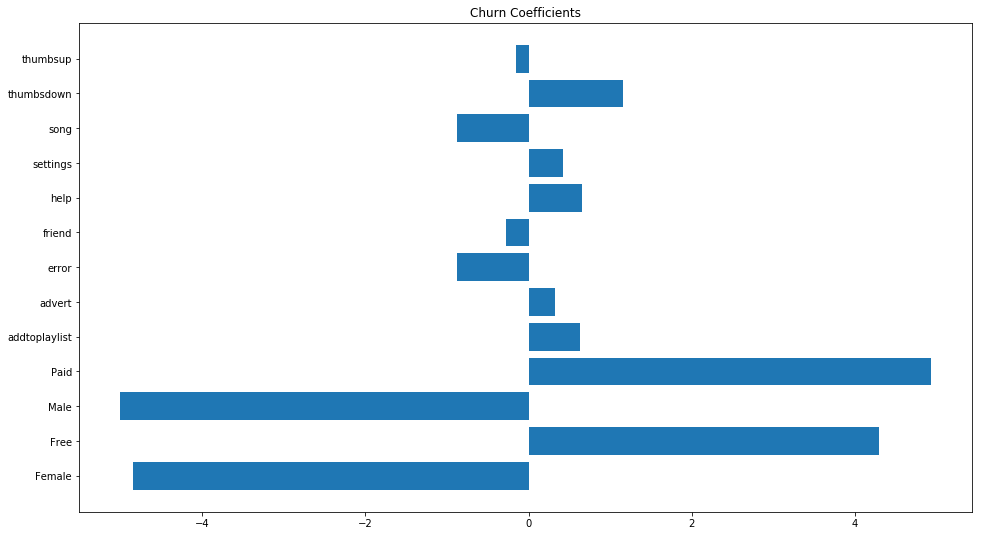

In [40]:
# Visualize the size of different coefficients
coef = ["thumbsdown", "thumbsup", "advert", "settings", "addtoplaylist","friend", "help", "error", 
        "song", "Male", "Female", "Paid", "Free"]
weight = lrModel.coefficients

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(coef, weight)
ax.set_title('Churn Coefficients')

# Show Plot
plt.show()

In [53]:
# See model R2
lrModelSummary = lrModel.summary
lrModelSummary.r2

0.5416801555580528

We can further develop our prediction model by trying various machine learning classifiers.  For now we'll start with a Random Forrest Classifier, a Support Vector Machine, and a Logisitc Regression Model.  
We will use the F1 score to tune our model since we do not have an even number of examples of churn vs no-churn.  Compared to accuracy, F1 helps insulate our model from simply selecting the more common occurence of no-churn most of the time as we try to tune it.

In [41]:
# Set up a Random Forest Classifier Model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [42]:
# Fit the model to the training data
rfModel = rf.fit(train)

In [43]:
# Create predictions for the test data set
predictions = rfModel.transform(test)

In [44]:
# Evaluate the F1 score for the basic Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
F1 = evaluator.evaluate(predictions)
print(F1)

0.6477130325814535


In [59]:
# Set up a Suport Vector Machine Classifier
sv = LinearSVC(labelCol="label", featuresCol="features")

In [60]:
# Fit the model to the training data
svModel = sv.fit(train)

In [64]:
# Create predictions for the test data set
prediction = svModel.transform(test)

In [65]:
# Create predictions for the test data set
F1 = evaluator.evaluate(prediction)
print(F1)

0.6368192335910605


In [66]:
# Set up a Logistic Regression Classifier
lr = LogisticRegression(labelCol="label", featuresCol="features")

In [67]:
# Fit the model to the training data
lrModel = lr.fit(train)

In [68]:
# Create predictions for the test data set
prediction = lrModel.transform(test)

In [69]:
# Create predictions for the test data set
F1 = evaluator.evaluate(prediction)
print(F1)

0.6886713982540287


By comparing the F1 scores of the base versions of different models, we see that the Logistic Regression is already off to a good start with an F1 of almost 0.7.  

We can try to further improve our model by doing a grid search of hyperparameters of a Logistic Regression Model.  Unfortunately, there are not too many options here, but we can consider whether or not we fit an intercept or standardize the data.

In [70]:
# Cross Validation setup for logistic regression
paramGrid = ParamGridBuilder().addGrid(lr.fitIntercept, [True, False]).addGrid(lr.standardization, [True, False]).build()

crossval = CrossValidator(estimator = lr, estimatorParamMaps = paramGrid, 
                          evaluator = MulticlassClassificationEvaluator(metricName="f1"))

In [71]:
# Train the cross validation model on the training data
cvModel = crossval.fit(train)

In [72]:
# Find average accuracy metrics for paramgrid results
cvModel.avgMetrics


[0.6420637251724449,
 0.6420637251724449,
 0.6558321231986786,
 0.6558321231986786]

Ultimately we find that not fitting an intercept provides the most effective model and that standardization doesn't make much of a difference.  This makes sense since the data was already pretty well standardized.  Further optimization and using the larger data set could likley improve this model even further.